In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import warnings
import matplotlib.colors as colors
import matplotlib.animation as animation
import matplotlib.lines as lines
import datetime
import math
%matplotlib notebook

In [2]:


warnings.filterwarnings(action='once')

!pip install sociophysicsdatahandler
from sociophysicsDataHandler import SociophysicsDataHandler

!cat auth.txt

dh = SociophysicsDataHandler()
dh.list_files('ut')

def fetchData(path):
  #Fetch and combine all data from a directory
  file_list = dh.list_files(path)
  print(dh.filelist)
  n = file_list.name.size
  df_array = np.empty(n, dtype=object)

  for i in range(n):
    dh.fetch_prorail_data_from_path(path + "/" + file_list.name[i]);
    #Convert the date time column to actual date time
    dh.df['date_time_utc'] = pd.to_datetime(dh.df['date_time_utc'], unit = 'ms')
    #Swap x and y
    column_titles = {'date_time_utc':'date_time_utc', 'tracked_object':'tracked_object', 'x_pos':'y_pos', 'y_pos':'x_pos'}
    dh.df.rename(columns = column_titles, inplace = True)

    df_array[i] = dh.df

  return pd.concat(df_array)


file_path = 'ehv/platform2.1/20220404/'

specific_file = 'ehv/platform2.1/20220404/EHV_Platform2.1_2022040409_trajectorie.parquet' 

# fetch the data from the first file
#df = fetchData(file_path);

#These lines might be redundant
dh.fetch_prorail_data_from_path(specific_file)
dh.df['date_time_utc'] = pd.to_datetime(dh.df['date_time_utc'], unit = 'ms')
column_titles = {'date_time_utc':'date_time_utc', 'tracked_object':'tracked_object', 'x_pos':'y_pos', 'y_pos':'x_pos'}
dh.df.rename(columns = column_titles, inplace = True)

df = dh.df
dh.fetch_background_image_from_path('ehv/background_images/EHV.Perron2.1_multisensor.png')
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
'cat' is not recognized as an internal or external command,
operable program or batch file.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system

targeting path /storage/surfsara/ProRail_USE_LL_data/ut
Files listed. Accessible as <this-object>.filelist
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20220404/EHV_Platform2.1_2022040409_trajectorie.parquet
data fetched. Accessible as <this-object>.df
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/background_images/EHV.Perron2.1_multisensor.png
background fetched. Accessible as <this-object>.bg


,date_time_utc,tracked_object,y_pos,x_pos,datetime
0,2022-04-04 07:00:00,4222520,-2102.0,62187.0,2022-04-04 09:00:00+02:00
1,2022-04-04 07:00:00,4222553,2395.0,10207.0,2022-04-04 09:00:00+02:00
2,2022-04-04 07:00:00,4222554,1519.0,24356.0,2022-04-04 09:00:00+02:00
3,2022-04-04 07:00:00,4222590,-641.0,27013.0,2022-04-04 09:00:00+02:00
4,2022-04-04 07:00:00,4222607,433.0,42440.0,2022-04-04 09:00:00+02:00


In [3]:
def checkBounds(df, limits, x_tag = 'x_pos', y_tag = 'y_pos'):
  x_lower = limits[0]
  x_upper = limits[1]
  y_lower = limits[2]
  y_upper = limits[3]

  within_xbounds_series = (df[x_tag] < x_upper) & (df[x_tag] > x_lower)
  within_ybounds_series = (df[y_tag] < y_upper) & (df[y_tag] > y_lower)
  within_bounds_series = within_xbounds_series & within_ybounds_series
  return within_bounds_series

def above_line(df, line, alpha, x_tag='x_pos',y_tag='y_pos'):
    above_line_series = df[y_tag] > - math.atan(alpha/360*2*math.pi)*(df[x_tag]-line[0])+line[1]
    return above_line_series

def below_line(df, line, alpha, x_tag='x_pos',y_tag='y_pos'):
    below_line_series = df[y_tag] < - math.atan(alpha/360*2*math.pi)*(df[x_tag]-line[0])+line[1]
    return below_line_series

df_grouped_by_id = df.groupby('tracked_object')
df_object_start_location = df_grouped_by_id.first()
df_object_end_location = df_grouped_by_id.last()

#Limits of the boarding area on the upper side (1) and lower side (2) of the platform in Eindhoven
#boarding_limits_1 = [-2e4, 8e4, 2e3, 5e3] #x_lower, x_upper, y_lower, y_upper
#boarding_limits_2 = [-2e4, 8e4, -0.65e4,-1.2e4] #x_lower, x_upper, y_lower, y_upper

alpha = 0.8 
boarding_line_1 = [-2e4,2e3] #x, y, angle (degrees)
dx = 5e4
boarding_line_1.append(boarding_line_1[0]+dx) # [2]: x of point 2
boarding_line_1.append(boarding_line_1[1]-dx*math.tan(alpha/360*2*math.pi)) # [3]: y of point 2

boarding_line_2 = [-2e4,-0.65e4] #x, y, angle (degrees)
dx = 5e4
boarding_line_2.append(boarding_line_2[0]+dx) # [2]: x of point 2
boarding_line_2.append(boarding_line_2[1]-dx*math.tan(alpha/360*2*math.pi)) # [3]: y of point 2

#vertical line
boarding_line_3 = [70000,-15000,70000,10000]
boarding_line_4 = [10000,-15000,10000,10000]




#If start location is above line 1, offboarding. same for below line 2. Also to the right of the vertical line
offboarding_1 = above_line(df_object_start_location,boarding_line_1,alpha)
offboarding_2 = below_line(df_object_start_location,boarding_line_2,alpha)
offboarding_3 = (df_object_start_location['x_pos']>boarding_line_3[0])
offboarding = offboarding_1 | offboarding_2 | offboarding_3

#If start location is in boarding area people are offboarding
#offboarding_1 = checkBounds(df_object_start_location, boarding_limits_1) 
#offboarding_2 = checkBounds(df_object_start_location, boarding_limits_2) 
#offboarding = offboarding_1 | offboarding_2
#df_grouped_by_id['offboarding'] = offboarding
#If end location is in boarding area people are onboarding 
#onboarding_1 = checkBounds(df_object_end_location, boarding_limits_1)  
#onboarding_2 = checkBounds(df_object_end_location, boarding_limits_2)  
#df_grouped_by_id['onboarding'] = onboarding

#If end location is above line 1, onboarding. same for below line 2.
onboarding_1 = above_line(df_object_end_location,boarding_line_1,alpha)
onboarding_2 = below_line(df_object_end_location,boarding_line_2,alpha)
onboarding_3 = (df_object_end_location['x_pos']>boarding_line_3[0])
onboarding = onboarding_1 | onboarding_2 | onboarding_3

df_object_start_location['offboarding'] = offboarding
df_object_end_location['onboarding'] = onboarding
offboarding.value_counts(), onboarding.value_counts()


#for index in df_object_start_location[df_object_start_location['offboarding']==True].itertuples():
    #print(index)
#    df.loc[[df['tracked_object']==index[0]],['onboarding_or_offboarding']] = 1
df['onboarding_or_offboarding'] = 0
df['offboarding'] = df['tracked_object'].map(df_object_start_location['offboarding'])
df['onboarding'] = df['tracked_object'].map(df_object_end_location['onboarding'])
print(df['offboarding'].value_counts())
df.loc[df['onboarding'] == True, 'onboarding_or_offboarding'] = 1
df.loc[df['offboarding'] == True, 'onboarding_or_offboarding'] = 2
df['onboarding_or_offboarding'].value_counts()
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False    1193830
True      511395
Name: offboarding, dtype: int64


1    607639
0    586191
2    511395
Name: onboarding_or_offboarding, dtype: int64

<IPython.core.display.Javascript object>


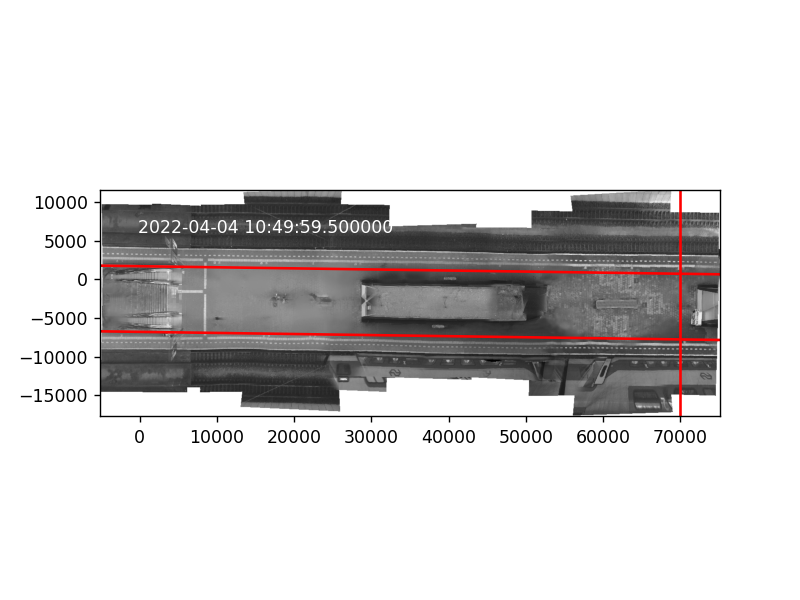

In [18]:
xmin = -5134
ymin = -17731
xmax =  75135
ymax =  11645

cmap = colors.LinearSegmentedColormap.from_list("",["black","blue","red"])#("",["black","black"])
#rect1 = patches.Rectangle((boarding_limits_1[0],boarding_limits_1[2]),boarding_limits_1[1]-boarding_limits_1[0],boarding_limits_1[3]-boarding_limits_1[2],fill=False,color="red",linewidth=2,angle=-0.8)
#rect2 = patches.Rectangle((boarding_limits_2[0],boarding_limits_2[2]),boarding_limits_2[1]-boarding_limits_2[0],boarding_limits_2[3]-boarding_limits_2[2],fill=False,color="red",linewidth=2,angle=-0.8)





class AnimatedScatter:
    
    def __init__(self):
        
        self.fig, self.ax = plt.subplots()
        self.ani = animation.FuncAnimation(self.fig, self.update, init_func = self.setup_plot, interval = 100, blit=False)
        
    def setup_plot(self):
        self.date_time = datetime.datetime(year=2022,month=4,day=4,hour=7,minute=2)
        # 2022 september 28th: 18:40, 19:06, 17:38, 17:50
        temp_df = df[df['date_time_utc'] == self.date_time].copy()
        x = temp_df['x_pos']
        y = temp_df['y_pos']
        on_or_off = temp_df['onboarding_or_offboarding']
        self.scat = self.ax.scatter(x,y,c=on_or_off,cmap=cmap,s=5)
        #plt.imshow(dh.bg)
        self.ax.axis([xmin,xmax,ymin,ymax])
        self.txt = plt.text(-200,6000, self.date_time, c='white')
        
        line1 = lines.Line2D([], [], color="none", marker='o', markerfacecolor="red",markeredgecolor="none")
        line2 = lines.Line2D([], [], color="none", marker='o', markerfacecolor="blue",markeredgecolor="none")
        
        #plt.legend((line1,line2),('offboarding','onboarding'),numpoints=1,loc=1)
        
        #plt.gca().add_patch(rect1)
        #plt.gca().add_patch(rect2)
        
        plt.axline([boarding_line_1[0],boarding_line_1[1]],[boarding_line_1[2],boarding_line_1[3]],c='red')
        plt.axline([boarding_line_2[0],boarding_line_2[1]],[boarding_line_2[2],boarding_line_2[3]],c='red')
        plt.axline([boarding_line_3[0],boarding_line_3[1]],[boarding_line_3[2],boarding_line_3[3]],c='red')
        #plt.axline([boarding_line_4[0],boarding_line_4[1]],[boarding_line_4[2],boarding_line_4[3]],c='red')
        return self.scat,

    def update(self, i):
        
        self.date_time =  self.date_time + datetime.timedelta(milliseconds = 500) # we can change timedelta, should be multiple of 100
        temp_df = df[df['date_time_utc'] ==  self.date_time].copy()
        x = temp_df['x_pos']
        y = temp_df['y_pos']
        on_or_off = temp_df['onboarding_or_offboarding']
        self.scat.set_offsets(np.c_[x,y])
        self.scat.set_array(on_or_off)
        self.txt.set_text( self.date_time)
        return self.scat,
        
a = AnimatedScatter()

plt.imshow(dh.bg,zorder = 0, extent=[xmin, xmax, ymin, ymax])
plt.show()
# a.setup_plot()
# a.update(1)








